In [1]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import gc
import re
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, losses
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.utils import plot_model

seed = 1
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from openslide import open_slide, __library_version__ as openslide_version
from PIL import Image
from skimage.color import rgb2gray

from google.colab import drive
drive.mount('/content/drive')

from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

RAW_DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data"
PROCESSED_DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/ADL/project/processed_data"
POS_DATA_DIR = os.path.join(PROCESSED_DATA_DIR, "positive")
NEG_DATA_DIR = os.path.join(PROCESSED_DATA_DIR, "negative")
MODEL_DIR = "/content/drive/MyDrive/Colab Notebooks/ADL/project/model"
RES_DIR = "/content/drive/MyDrive/Colab Notebooks/ADL/project/result"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im


def read_full_image(slide_num, level=6, ifmask=False):

  slide_name = f"Copy of tumor_{slide_num}.tif"
  tumor_mask_name = f"Copy of tumor_{slide_num}_mask.tif"

  slide_path = os.path.join(RAW_DATA_DIR, slide_name)
  tumor_mask_path = os.path.join(RAW_DATA_DIR, tumor_mask_name)

  if not ifmask:
    slide = open_slide(slide_path)
    print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                            slide.level_dimensions[level][0], 
                                                            slide.level_dimensions[level][1]))
    slide_image = read_slide(
        slide, x=0, y=0, level=level, 
        width=slide.level_dimensions[level][0], 
        height=slide.level_dimensions[level][1]) 
    
    return slide_image

  else:
    tumor_mask = open_slide(tumor_mask_path)
    print ("Read WSI from %s with width: %d, height: %d" % (tumor_mask_path, 
                                                            tumor_mask.level_dimensions[level][0], 
                                                            tumor_mask.level_dimensions[level][1]))

    mask_image = read_slide(
        tumor_mask, x=0, y=0, level=level, 
        width=tumor_mask.level_dimensions[level][0], 
        height=tumor_mask.level_dimensions[level][1])[:,:,0]

    return mask_image

# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked


In [4]:
def get_center(slide_image, x_level, y_level, level=6, patch_len=299):
  assert 0 <= x_level + patch_len-1 <= slide_image.shape[0]
  assert 0 <= y_level + patch_len-1 <= slide_image.shape[1]
  assert 0 <= x_level <= slide_image.shape[0]
  assert 0 <= y_level <= slide_image.shape[1]

  factor = 2 ** level
  xc_level = x_level + patch_len//2
  yc_level = y_level + patch_len//2
  xc_0 = xc_level * factor
  yc_0 = yc_level * factor

  return xc_0, yc_0


def get_patch_from_center(slide_image, xc_0, yc_0, level=6, patch_len=299):
  factor = 2 ** level
  xc_level = xc_0 // factor
  yc_level = yc_0 // factor
  x_level = xc_level - patch_len//2
  y_level = yc_level - patch_len//2
  
  assert 0 <= x_level + patch_len-1 <= slide_image.shape[0]
  assert 0 <= y_level + patch_len-1 <= slide_image.shape[1]
  assert 0 <= x_level <= slide_image.shape[0]
  assert 0 <= y_level <= slide_image.shape[1]

  return slide_image[
        x_level: x_level + patch_len, y_level: y_level + patch_len]
        

def delete_gray(slide_image, threshold=0.4, show=False):
  tissue_pixels = find_tissue_pixels(slide_image)
  percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
  if show:
    print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 
  
  if percent_tissue >= threshold:
    return True
  else:
    return False

def get_target(mask_region, patch_len=299, target_size=128):
  offset = (patch_len - target_size)//2
  target = mask_region[offset: offset+128, offset: offset+128]
  return 1.0 if target.sum() != 0 else 0.0

In [5]:
def get_patches_from_center(multi_slide_images, xc_0, yc_0, level_lst=[5,6,7], patch_len=299):
  multi_pitches = []
  for i, level in enumerate(level_lst):
    factor = 2 ** level
    xc_level = xc_0 // factor
    yc_level = yc_0 // factor

    x_level = xc_level - patch_len//2
    y_level = yc_level - patch_len//2

    slide_image = multi_slide_images[i]
    assert 0 <= x_level + patch_len-1 <= slide_image.shape[0]
    assert 0 <= y_level + patch_len-1 <= slide_image.shape[1]
    assert 0 <= x_level <= slide_image.shape[0]
    assert 0 <= y_level <= slide_image.shape[1]

    multi_pitches.append(slide_image[
        x_level: x_level + patch_len, y_level: y_level + patch_len])
    
  return multi_pitches

In [6]:
def allocate_ones(mask_image, patch_len=299):
  # Allocate ones
  allocated_ones = np.where(mask_image == 1)
  all_ones = list(zip(allocated_ones[0], allocated_ones[1]))
  print("The number of tumor pixels", len(all_ones))

  all_ones = [
      (x, y) for x, y in all_ones if (
          patch_len//2 < x < mask_image.shape[0]-patch_len//2) and (
              patch_len//2 < y < mask_image.shape[1]-patch_len//2)]
  random.shuffle(all_ones)
  print("The number of tumor pixels after filter", len(all_ones))
  return all_ones


def allocate_zeros(slide_image, mask_image, patch_len=299):
  tissue_pixels = find_tissue_pixels(slide_image)
  tissue_pixels = set(tissue_pixels)
  print("The number of tissue", len(tissue_pixels))

  allocated_ones = np.where(mask_image == 1)
  all_ones = list(zip(allocated_ones[0], allocated_ones[1]))
  all_ones = set(all_ones)
  print("The number of tumor", len(all_ones))

  tissue_pixels = list(tissue_pixels.difference(all_ones))
  print("The number of normal tissue", len(tissue_pixels))

  tissue_pixels = [
      (x, y) for x, y in tissue_pixels if (
          patch_len//2 < x < slide_image.shape[0]-patch_len//2) and (
              patch_len//2 < y < slide_image.shape[1]-patch_len//2)]
  random.shuffle(tissue_pixels)
  print("The number of normal tissue after filter", len(tissue_pixels))
  return tissue_pixels

In [7]:
test_file = ["091", "075", "094", "084"]
sampling_times = 5
nsamples = 200

In [8]:
#@title Base Model
patch_len=299

model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', 
                        input_shape=(patch_len, patch_len, 3)))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

checkpoint_path = os.path.join(MODEL_DIR, "model_5_200.ckpt")
# Loads the weights
model.load_weights(checkpoint_path)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 297, 297, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 148, 148, 16)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 350464)            0         
                                                                 
 dense (Dense)               (None, 32)                11214880  
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 11,215,361
Trainable params: 11,215,361
Non-trainable params: 0
____________________________________________

In [10]:
true_label_lst = []
pred_res_lst = []
pred_label_lst = []

for slide_num in test_file:
  for s_i in range(sampling_times):
    print("\nPredict for", slide_num, s_i)

    # negative samples
    pos_file = os.path.join(POS_DATA_DIR, f"{slide_num}_567_{s_i}.npy")
    
    if not os.path.exists(pos_file):
      print(f"!!! No {pos_file}, please check!!!")
    
    else:
      print("------Load samples-------")
      pos_pitch_lst = np.load(pos_file)[0]

      pred_res = model.predict(pos_pitch_lst)
      pred_res_lst.extend(pred_res.reshape(-1))
      pred_label = (pred_res > 0.5).astype("int32")
      pred_label_lst.extend(pred_label.reshape(-1))
      true_label_lst.extend([1]*len(pred_label))

    # negative samples
    neg_file = os.path.join(NEG_DATA_DIR, f"{slide_num}_567_{s_i}.npy")

    if not os.path.exists(neg_file):
      print(f"!!! No {neg_file}, please check!!!")

    else:
      print("------Load samples-------")
      neg_pitch_lst = np.load(neg_file)[0]

      pred_res = model.predict(neg_pitch_lst)
      pred_res_lst.extend(pred_res.reshape(-1))
      pred_label = (pred_res > 0.5).astype("int32")    
      pred_label_lst.extend(pred_label.reshape(-1))
      true_label_lst.extend([0]*len(pred_label))

target_names = ['normal', 'cancer']
print(classification_report(true_label_lst, pred_label_lst, target_names=target_names))

prediction_df = pd.DataFrame({
    "true_label_lst": true_label_lst,
    "pred_res_lst": pred_res_lst,
    "pred_label_lst": pred_label_lst
})

print("Save prediction")
prediction_file = os.path.join(RES_DIR, "pred_5_200.csv")
prediction_df.to_csv(prediction_file, index=False)



Predict for 091 0
------Load samples-------
7/7 [==============================] - 2s 30ms/step
------Load samples-------
7/7 [==============================] - 0s 21ms/step

Predict for 091 1
------Load samples-------
7/7 [==============================] - 0s 21ms/step
------Load samples-------
7/7 [==============================] - 0s 20ms/step

Predict for 091 2
------Load samples-------
7/7 [==============================] - 0s 21ms/step
------Load samples-------
7/7 [==============================] - 0s 20ms/step

Predict for 091 3
------Load samples-------
7/7 [==============================] - 0s 20ms/step
------Load samples-------
7/7 [==============================] - 0s 21ms/step

Predict for 091 4
------Load samples-------
7/7 [==============================] - 0s 20ms/step
------Load samples-------
7/7 [==============================] - 0s 20ms/step

Predict for 075 0
------Load samples-------
7/7 [==============================] - 0s 20ms/step
------Load samples-------
7/

In [27]:
#@title One-zoom Model (5)
patch_len = 299

inception_zoom1 = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(patch_len, patch_len, 3))

# freeze the inception model to increase training speed
inception_zoom1.trainable = False

# creat the base model
model_zoom1 = models.Sequential()
model_zoom1.add(inception_zoom1)
model_zoom1.add(layers.GlobalAveragePooling2D())

input_zoom1 = layers.Input(shape=(patch_len, patch_len, 3))

encoded_zoom1 = model_zoom1(input_zoom1)

dense1 = layers.Dense(128, activation='relu')(encoded_zoom1)
drop_layer = layers.Dropout(0.5)(dense1)
dense2 = layers.Dense(32, activation='relu')(drop_layer)

output = layers.Dense(1, activation='sigmoid')(dense2)
model = models.Model(inputs=[input_zoom1], outputs=output)

model.summary()

checkpoint_path = os.path.join(MODEL_DIR, "model_onezoom_5_200.ckpt")
# Loads the weights
model.load_weights(checkpoint_path)

87910968/87910968 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 2048)              21802784  
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 32)                4128      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                              

In [28]:
true_label_lst = []
pred_res_lst = []
pred_label_lst = []

for slide_num in test_file:
  for s_i in range(sampling_times):
    print("\nPredict for", slide_num, s_i)

    # negative samples
    pos_file = os.path.join(POS_DATA_DIR, f"{slide_num}_567_{s_i}.npy")
    
    if not os.path.exists(pos_file):
      print(f"!!! No {pos_file}, please check!!!")
    
    else:
      print("------Load samples-------")
      pos_pitch_lst = np.load(pos_file)[0]

      pred_res = model.predict(pos_pitch_lst)
      pred_res_lst.extend(pred_res.reshape(-1))
      pred_label = (pred_res > 0.5).astype("int32")
      pred_label_lst.extend(pred_label.reshape(-1))
      true_label_lst.extend([1]*len(pred_label))

    # negative samples
    neg_file = os.path.join(NEG_DATA_DIR, f"{slide_num}_567_{s_i}.npy")

    if not os.path.exists(neg_file):
      print(f"!!! No {neg_file}, please check!!!")

    else:
      print("------Load samples-------")
      neg_pitch_lst = np.load(neg_file)[0]

      pred_res = model.predict(neg_pitch_lst)
      pred_res_lst.extend(pred_res.reshape(-1))
      pred_label = (pred_res > 0.5).astype("int32")    
      pred_label_lst.extend(pred_label.reshape(-1))
      true_label_lst.extend([0]*len(pred_label))

target_names = ['normal', 'cancer']
print(classification_report(true_label_lst, pred_label_lst, target_names=target_names))

prediction_df = pd.DataFrame({
    "true_label_lst": true_label_lst,
    "pred_res_lst": pred_res_lst,
    "pred_label_lst": pred_label_lst
})

print("Save prediction")
prediction_file = os.path.join(RES_DIR, "pred_onezoom_5_200.csv")
prediction_df.to_csv(prediction_file, index=False)



Predict for 091 0
------Load samples-------
7/7 [==============================] - 5s 273ms/step
------Load samples-------
7/7 [==============================] - 1s 116ms/step

Predict for 091 1
------Load samples-------
7/7 [==============================] - 1s 117ms/step
------Load samples-------
7/7 [==============================] - 1s 121ms/step

Predict for 091 2
------Load samples-------
7/7 [==============================] - 1s 121ms/step
------Load samples-------
7/7 [==============================] - 1s 118ms/step

Predict for 091 3
------Load samples-------
7/7 [==============================] - 1s 120ms/step
------Load samples-------
7/7 [==============================] - 1s 121ms/step

Predict for 091 4
------Load samples-------
7/7 [==============================] - 1s 121ms/step
------Load samples-------
7/7 [==============================] - 1s 117ms/step

Predict for 075 0
------Load samples-------
7/7 [==============================] - 1s 118ms/step
------Load sample

In [29]:
#@title Three-zooms Model (567)

patch_len = 299

inception_zoom1 = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(patch_len, patch_len, 3))

inception_zoom2 = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(patch_len, patch_len, 3))

inception_zoom3 = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(patch_len, patch_len, 3))

# freeze the inception model to increase training speed
inception_zoom1.trainable = False
inception_zoom2.trainable = False
inception_zoom3.trainable = False

# creat the base model
model_zoom1 = models.Sequential()
model_zoom1.add(inception_zoom1)
model_zoom1.add(layers.GlobalAveragePooling2D())

model_zoom2 = models.Sequential()
model_zoom2.add(inception_zoom2)
model_zoom2.add(layers.GlobalAveragePooling2D())

model_zoom3 = models.Sequential()
model_zoom3.add(inception_zoom3)
model_zoom3.add(layers.GlobalAveragePooling2D())

input_zoom1 = layers.Input(shape=(patch_len, patch_len, 3), name="input1")
input_zoom2 = layers.Input(shape=(patch_len, patch_len, 3), name="input2")
input_zoom3 = layers.Input(shape=(patch_len, patch_len, 3), name="input3")

encoded_zoom1 = model_zoom1(input_zoom1)
encoded_zoom2 = model_zoom2(input_zoom2)
encoded_zoom3 = model_zoom3(input_zoom3)

merged = layers.concatenate([encoded_zoom1, encoded_zoom2, encoded_zoom3])
dense1 = layers.Dense(256, activation='relu')(merged)
drop_layer = layers.Dropout(0.5)(dense1)
dense2 = layers.Dense(126, activation='relu')(drop_layer)

output = layers.Dense(1, activation='sigmoid')(dense2)
model = models.Model(inputs=[input_zoom1, input_zoom2, input_zoom3], outputs=output)

model.summary()

checkpoint_path = os.path.join(MODEL_DIR, "model_567_200.ckpt")
# Loads the weights
model.load_weights(checkpoint_path)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 input2 (InputLayer)            [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 input3 (InputLayer)            [(None, 299, 299, 3  0           []                               
                                )]                                                          

In [30]:
true_label_lst = []
pred_res_lst = []
pred_label_lst = []

for slide_num in test_file:
  for s_i in range(sampling_times):
    print("\nPredict for", slide_num, s_i)

    # negative samples
    pos_file = os.path.join(POS_DATA_DIR, f"{slide_num}_567_{s_i}.npy")
    
    if not os.path.exists(pos_file):
      print(f"!!! No {pos_file}, please check!!!")
    
    else:
      print("------Load samples-------")
      pos_pitch_lst = np.load(pos_file)
      input_dict = {
          "input1": pos_pitch_lst[0],
          "input2": pos_pitch_lst[1],
          "input3": pos_pitch_lst[2],
      }

      pred_res = model.predict(input_dict)

      del pos_pitch_lst
      gc.collect()

      pred_res_lst.extend(pred_res.reshape(-1))
      pred_label = (pred_res > 0.5).astype("int32")
      pred_label_lst.extend(pred_label.reshape(-1))
      true_label_lst.extend([1]*len(pred_label))

    # negative samples
    neg_file = os.path.join(NEG_DATA_DIR, f"{slide_num}_567_{s_i}.npy")

    if not os.path.exists(neg_file):
      print(f"!!! No {neg_file}, please check!!!")

    else:
      print("------Load samples-------")
      neg_pitch_lst = np.load(neg_file)

      input_dict = {
          "input1": neg_pitch_lst[0],
          "input2": neg_pitch_lst[1],
          "input3": neg_pitch_lst[2],
      }

      pred_res = model.predict(input_dict)

      del input_dict
      gc.collect()

      pred_res_lst.extend(pred_res.reshape(-1))
      pred_label = (pred_res > 0.5).astype("int32")    
      pred_label_lst.extend(pred_label.reshape(-1))
      true_label_lst.extend([0]*len(pred_label))

target_names = ['normal', 'cancer']
print(classification_report(true_label_lst, pred_label_lst, target_names=target_names))

prediction_df = pd.DataFrame({
    "true_label_lst": true_label_lst,
    "pred_res_lst": pred_res_lst,
    "pred_label_lst": pred_label_lst
})

print("Save prediction")
prediction_file = os.path.join(RES_DIR, "pred_567_200.csv")
prediction_df.to_csv(prediction_file, index=False)



Predict for 091 0
------Load samples-------
7/7 [==============================] - 6s 322ms/step
------Load samples-------
7/7 [==============================] - 2s 322ms/step

Predict for 091 1
------Load samples-------
7/7 [==============================] - 2s 323ms/step
------Load samples-------
7/7 [==============================] - 2s 329ms/step

Predict for 091 2
------Load samples-------
7/7 [==============================] - 2s 326ms/step
------Load samples-------
7/7 [==============================] - 2s 323ms/step

Predict for 091 3
------Load samples-------
7/7 [==============================] - 2s 324ms/step
------Load samples-------
7/7 [==============================] - 2s 321ms/step

Predict for 091 4
------Load samples-------
7/7 [==============================] - 2s 325ms/step
------Load samples-------
7/7 [==============================] - 2s 323ms/step

Predict for 075 0
------Load samples-------
7/7 [==============================] - 2s 324ms/step
------Load sample

In [31]:
#@title Three-zooms Model (357)

patch_len = 299

inception_zoom1 = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(patch_len, patch_len, 3))

inception_zoom2 = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(patch_len, patch_len, 3))

inception_zoom3 = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(patch_len, patch_len, 3))

# freeze the inception model to increase training speed
inception_zoom1.trainable = False
inception_zoom2.trainable = False
inception_zoom3.trainable = False

# creat the base model
model_zoom1 = models.Sequential()
model_zoom1.add(inception_zoom1)
model_zoom1.add(layers.GlobalAveragePooling2D())

model_zoom2 = models.Sequential()
model_zoom2.add(inception_zoom2)
model_zoom2.add(layers.GlobalAveragePooling2D())

model_zoom3 = models.Sequential()
model_zoom3.add(inception_zoom3)
model_zoom3.add(layers.GlobalAveragePooling2D())

input_zoom1 = layers.Input(shape=(patch_len, patch_len, 3), name="input1")
input_zoom2 = layers.Input(shape=(patch_len, patch_len, 3), name="input2")
input_zoom3 = layers.Input(shape=(patch_len, patch_len, 3), name="input3")

encoded_zoom1 = model_zoom1(input_zoom1)
encoded_zoom2 = model_zoom2(input_zoom2)
encoded_zoom3 = model_zoom3(input_zoom3)

merged = layers.concatenate([encoded_zoom1, encoded_zoom2, encoded_zoom3])
dense1 = layers.Dense(256, activation='relu')(merged)
drop_layer = layers.Dropout(0.5)(dense1)
dense2 = layers.Dense(126, activation='relu')(drop_layer)

output = layers.Dense(1, activation='sigmoid')(dense2)
model = models.Model(inputs=[input_zoom1, input_zoom2, input_zoom3], outputs=output)

model.summary()

model.compile(loss=losses.BinaryCrossentropy(from_logits=False),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.5))

checkpoint_path = os.path.join(MODEL_DIR, "model_357_200.ckpt")
# Loads the weights
model.load_weights(checkpoint_path)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 input2 (InputLayer)            [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 input3 (InputLayer)            [(None, 299, 299, 3  0           []                               
                                )]                                                          

In [32]:
true_label_lst = []
pred_res_lst = []
pred_label_lst = []

for slide_num in test_file:
  for s_i in range(sampling_times):
    print("\nPredict for", slide_num, s_i)

    # negative samples
    pos_file = os.path.join(POS_DATA_DIR, f"{slide_num}_357_{s_i}.npy")
    
    if not os.path.exists(pos_file):
      print(f"!!! No {pos_file}, please check!!!")
    
    else:
      print("------Load samples-------")
      pos_pitch_lst = np.load(pos_file)
      input_dict = {
          "input1": pos_pitch_lst[0],
          "input2": pos_pitch_lst[1],
          "input3": pos_pitch_lst[2],
      }

      pred_res = model.predict(input_dict)

      del pos_pitch_lst
      gc.collect()

      pred_res_lst.extend(pred_res.reshape(-1))
      pred_label = (pred_res > 0.5).astype("int32")
      pred_label_lst.extend(pred_label.reshape(-1))
      true_label_lst.extend([1]*len(pred_label))

    # negative samples
    neg_file = os.path.join(NEG_DATA_DIR, f"{slide_num}_357_{s_i}.npy")

    if not os.path.exists(neg_file):
      print(f"!!! No {neg_file}, please check!!!")

    else:
      print("------Load samples-------")
      neg_pitch_lst = np.load(neg_file)

      input_dict = {
          "input1": neg_pitch_lst[0],
          "input2": neg_pitch_lst[1],
          "input3": neg_pitch_lst[2],
      }

      pred_res = model.predict(input_dict)

      del input_dict
      gc.collect()

      pred_res_lst.extend(pred_res.reshape(-1))
      pred_label = (pred_res > 0.5).astype("int32")    
      pred_label_lst.extend(pred_label.reshape(-1))
      true_label_lst.extend([0]*len(pred_label))

target_names = ['normal', 'cancer']
print(classification_report(true_label_lst, pred_label_lst, target_names=target_names))

prediction_df = pd.DataFrame({
    "true_label_lst": true_label_lst,
    "pred_res_lst": pred_res_lst,
    "pred_label_lst": pred_label_lst
})

print("Save prediction")
prediction_file = os.path.join(RES_DIR, "pred_357_200.csv")
prediction_df.to_csv(prediction_file, index=False)



Predict for 091 0
------Load samples-------
7/7 [==============================] - 7s 351ms/step
------Load samples-------
7/7 [==============================] - 2s 348ms/step

Predict for 091 1
------Load samples-------
7/7 [==============================] - 2s 353ms/step
------Load samples-------
7/7 [==============================] - 2s 357ms/step

Predict for 091 2
------Load samples-------
7/7 [==============================] - 2s 357ms/step
------Load samples-------
7/7 [==============================] - 2s 348ms/step

Predict for 091 3
------Load samples-------
7/7 [==============================] - 2s 350ms/step
------Load samples-------
7/7 [==============================] - 2s 350ms/step

Predict for 091 4
------Load samples-------
7/7 [==============================] - 2s 353ms/step
------Load samples-------
7/7 [==============================] - 2s 351ms/step

Predict for 075 0
------Load samples-------
7/7 [==============================] - 2s 350ms/step
------Load sample

In [33]:
#@title Load Data and make plots
prediction_file = os.path.join(RES_DIR, "pred_5_200.csv")
base_pred = pd.read_csv(prediction_file)
true_label_lst = base_pred["true_label_lst"]
base_pred_res_lst = base_pred["pred_res_lst"]

prediction_file = os.path.join(RES_DIR, "pred_onezoom_5_200.csv")
one_zoom_pred = pd.read_csv(prediction_file)
one_zoom_pred_res_lst = one_zoom_pred["pred_res_lst"]

prediction_file = os.path.join(RES_DIR, "pred_567_200.csv")
three_zoom_567_pred = pd.read_csv(prediction_file)
three_zoom_567_pred_res_lst = three_zoom_567_pred["pred_res_lst"]

prediction_file = os.path.join(RES_DIR, "pred_357_200.csv")
three_zoom_357_pred = pd.read_csv(prediction_file)
three_zoom_357_pred_res_lst = three_zoom_357_pred["pred_res_lst"]

In [36]:
random_guess = [0] * len(pred_res_lst)

Random Guess: ROC AUC=0.500
Base Model: ROC AUC=0.698
One-zoom (5) Model: ROC AUC=0.775
Three-zooms (567) Model: ROC AUC=0.722
Three-zooms (357) Model: ROC AUC=0.535


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-pack

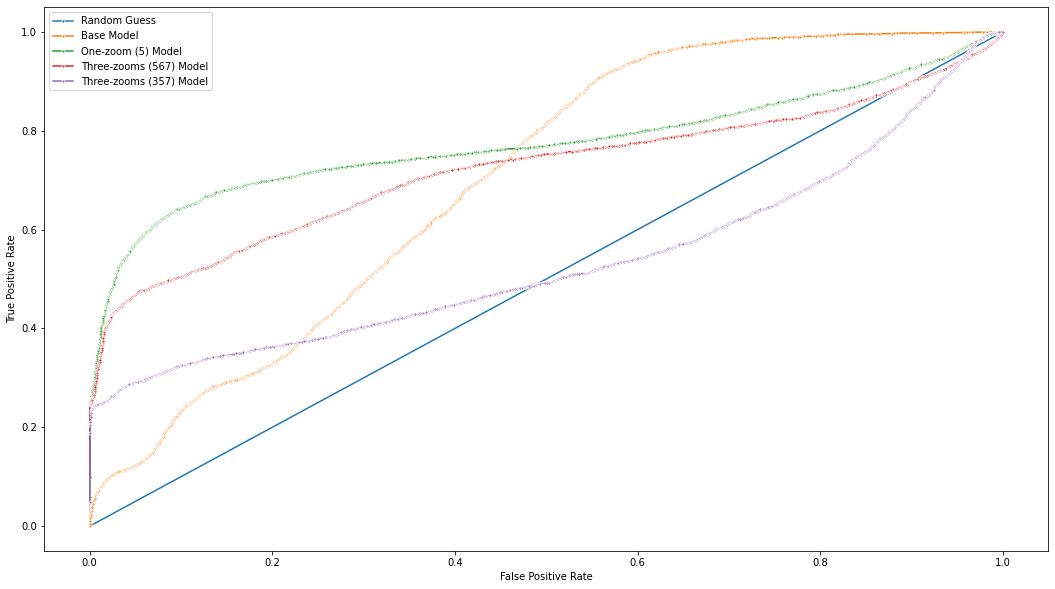

In [39]:
# calculate scores
rg_auc = roc_auc_score(true_label_lst, random_guess)
base_auc = roc_auc_score(true_label_lst, base_pred_res_lst)
one_zoom_auc = roc_auc_score(true_label_lst, one_zoom_pred_res_lst)
three_zoom_567_auc = roc_auc_score(true_label_lst, three_zoom_567_pred_res_lst)
three_zoom_357_auc = roc_auc_score(true_label_lst, three_zoom_357_pred_res_lst)

# summarize scores
print('Random Guess: ROC AUC=%.3f' % (rg_auc))
print('Base Model: ROC AUC=%.3f' % (base_auc))
print('One-zoom (5) Model: ROC AUC=%.3f' % (one_zoom_auc))
print('Three-zooms (567) Model: ROC AUC=%.3f' % (three_zoom_567_auc))
print('Three-zooms (357) Model: ROC AUC=%.3f' % (three_zoom_357_auc))

fig, ax = plt.subplots(figsize=(18,10))

# calculate roc curves
rg_fpr, rg_tpr, _ = roc_curve(true_label_lst, random_guess)
base_fpr, base_tpr, _ = roc_curve(true_label_lst, base_pred_res_lst)
one_zoom_fpr, one_zoom_tpr, _ = roc_curve(true_label_lst, one_zoom_pred_res_lst)
three_zoom_567_fpr, three_zoom_567_tpr, _ = roc_curve(true_label_lst, three_zoom_567_pred_res_lst)
three_zoom_357_fpr, three_zoom_357_tpr, _ = roc_curve(true_label_lst, three_zoom_357_pred_res_lst)

# plot the roc curve for the model
sns.lineplot(rg_fpr, rg_tpr, marker='.', label='Random Guess')
sns.lineplot(base_fpr, base_tpr, marker='.', label='Base Model')
sns.lineplot(one_zoom_fpr, one_zoom_tpr, marker='.', label='One-zoom (5) Model')
sns.lineplot(three_zoom_567_fpr, three_zoom_567_tpr, marker='.', label='Three-zooms (567) Model')
sns.lineplot(three_zoom_357_fpr, three_zoom_357_tpr, marker='.', label='Three-zooms (357) Model')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()